# Building a non-linear gravity inversion from scratch (almost)

In this notebook, we'll build a non-linear gravity inversion to estimate the relief of a sedimentary basin. We'll implement smoothness regularization and see its effects on the solution. We'll also see how we can break the inversion by adding random noise, abusing regularization, and breaking the underlying assumptions.

## Imports

We'll use the basic scientific Python stack for this tutorial plus a custom module with the forward modelling function (based on the code from the [Harmonica](https://github.com/fatiando/harmonica) library).

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

This is a little trick to make the resolution of the matplotlib figures better for larger screens.

In [38]:
plt.rc("figure", dpi=150)

## Assumption

Here are some assumptions we'll work with:

1. The basin is much larger in the y-dimension so we'll assume it's infinite (reducing the problem to 2D)
1. The gravity disturbance is entirely due to the sedimentary basin
1. The top of the basin is a flat surface at $z=0$
1. The data are measured at a constant height of $z=0$

## Making synthetic data

First, we'll explore the forward modelling function and create some synthetic data.

In [ ]:
def forward_model(depths, basin_boundaries, density, x):
    """
    """
    # Computation points
    easting = x
    northing = np.zeros_like(x)
    upward = np.zeros_like(x)
    
    
     # Iterate over computation points and prisms
    for l in range(coordinates[0].size):
        for m in range(prisms.shape[0]):
            # Iterate over the prism boundaries to compute the result of the
            # integration (see Nagy et al., 2000)
            for i in range(2):
                for j in range(2):
                    for k in range(2):
                        shift_east = prisms[m, 1 - i]
                        shift_north = prisms[m, 3 - j]
                        shift_upward = prisms[m, 5 - k]
                        # If i, j or k is 1, the shift_* will refer to the
                        # lower boundary, meaning the corresponding term should
                        # have a minus sign
                        out[l] += (
                            density[m]
                            * (-1) ** (i + j + k)
                            * kernel(
                                shift_east - coordinates[0][l],
                                shift_north - coordinates[1][l],
                                shift_upward - coordinates[2][l],
                            )
    
    si2mgal = 1e5
    # The gravitational constant in SI units
    GRAVITATIONAL_CONST = 0.00000000006673
    result *= GRAVITATIONAL_CONST * density * si2mgal
    return result 

In [3]:
def make_prisms(depths, basin_boundaries):
    """
    Generate a list of 3D prisms from the depths and boundaries.
    """
    boundaries = np.linspace(*basin_boundaries, depths.size + 1)
    infinity = np.full_like(depths, 500e3)
    prisms = np.transpose([
        boundaries[:-1],      # east
        boundaries[1:],       # west
        -infinity,            # south
        infinity,             # north
        -depths,              # bottom
        np.zeros_like(depths) # top
    ])
    return prisms

In [45]:
def plot_prisms(
    depths, basin_boundaries, ax=None, color="#00000000", edgecolor="black", linewidth=1, label=None, figsize=(9, 3.5)
):
    """
    Plot the prism model using matplotlib.
    """
    # Create lines with the outline of the prisms
    boundaries = np.linspace(*basin_boundaries, depths.size + 1)    
    x = [boundaries[0]]
    y = [0]
    for i in range(depths.size):
        x.extend([boundaries[i], boundaries[i + 1]])
        y.extend([depths[i], depths[i]])
    x.append(boundaries[-1])
    y.append(0)
    x = np.array(x) / 1000
    y = np.array(y) / 1000
    # Plot the outline with optional filling
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(111)
        ax.set_xlabel("x [km]")
        ax.set_ylabel("depth [km]")
    ax.fill_between(x, y, color=color, edgecolor=edgecolor, linewidth=linewidth, label=label)
    ax.set_ylim(max(y)*1.05, 0)
    return ax

<AxesSubplot:xlabel='x [km]', ylabel='depth [km]'>

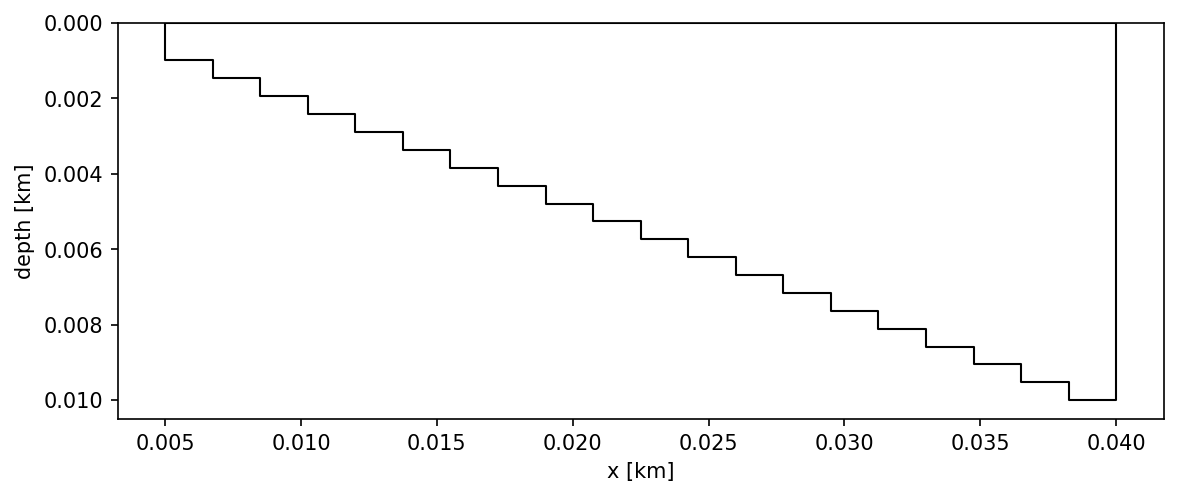

In [46]:
plot_prisms(depths, basin_boundaries)